In [1]:
# Thanks to https://www.kaggle.com/wcukierski/example-metric-implementation

import csv
import numpy as np
from scipy import ndimage as ndi
from tqdm import tqdm

def masks2labels(masks, roll = False):
    num_mask = masks.shape[2 if roll else 0]
    rolled = np.rollaxis(masks, 2) if roll else masks
    mask_list = list(rolled)
    labels = np.zeros((masks.shape[0 if roll else 1], masks.shape[1 if roll else 2]), dtype=np.uint16)
    for i in range(num_mask):
        mask_list[i] = np.where(mask_list[i] > 0, 1, 0)
        labels = np.where(mask_list[i] > 0, i + 1, labels)
    return labels

def label_loss(label_true, label_pred):
    true_objects = len(np.unique(label_true))
    pred_objects = len(np.unique(label_pred))
    
    intersection = np.histogram2d(label_true.flatten(), label_pred.flatten(), bins=(true_objects, pred_objects))[0]

    area_true = np.histogram(label_true, bins = true_objects)[0]
    area_pred = np.histogram(label_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)
    
    union = area_true + area_pred - intersection

    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9
    
    iou = intersection / union

    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    prec = []

    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        p = tp / (tp + fp + fn)
        prec.append(p)
    return np.mean(prec)


def compute_map_nuclei(true_masks, pred_masks):
    true_labels = masks2labels(true_masks)
    pred_labels = masks2labels(pred_masks)
    return label_loss(true_labels, pred_labels)

def get_stage1_masks(true_filename, pred_filename):
    stage1_mask_list = {}
    stage1_test_sizes = {}
    stage1_pred_mask_list = {}
    with open(true_filename, newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            rleNumbers = [int(s) for s in row['EncodedPixels'].split(' ')]
            rlePairs = np.array(rleNumbers).reshape(-1,2)
            if row['ImageId'] not in stage1_test_sizes:
                stage1_test_sizes[row['ImageId']] = [int(row['Height']), int(row['Width'])]
            height = stage1_test_sizes[row['ImageId']][0]
            width = stage1_test_sizes[row['ImageId']][1]
            
            mask = np.zeros(height*width,dtype=np.uint8)
            for index,length in rlePairs:
                index -= 1
                mask[index:index+length] = 1
            mask = mask.reshape(width,height)
            mask = mask.T
            if row['ImageId'] not in stage1_mask_list:
                stage1_mask_list[row['ImageId']] = []
            stage1_mask_list[row['ImageId']].append(mask)
    
    with open(pred_filename, newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            rleNumbers = [int(s) for s in row['EncodedPixels'].split(' ')]
            rlePairs = np.array(rleNumbers).reshape(-1,2)
            height = stage1_test_sizes[row['ImageId']][0]
            width = stage1_test_sizes[row['ImageId']][1]
            mask = np.zeros(height*width,dtype=np.uint8)
            for index,length in rlePairs:
                index -= 1
                mask[index:index+length] = 1
            mask = mask.reshape(width,height)
            mask = mask.T
            if row['ImageId'] not in stage1_pred_mask_list:
                stage1_pred_mask_list[row['ImageId']] = []
            stage1_pred_mask_list[row['ImageId']].append(mask)
    
    APs = []
    for imageId in tqdm(stage1_mask_list):
        true_masks = np.array(stage1_mask_list[imageId])
        pred_masks = np.array(stage1_pred_mask_list[imageId])
        APs.append(compute_map_nuclei(true_masks, pred_masks))
    
    return np.mean(APs)
    


In [2]:
import os
import zipfile

In [3]:
filenames = sorted(os.listdir('sub/'))
print(filenames)

['.DS_Store', '6893343.zip', '6901382.zip', '6915237.zip', '6931365.zip', '6932440.zip', '6932678.zip', '6934002.zip', '7107849.zip', '7107948.zip', '7107957.zip', '7107961.zip', '7108097.zip', '7118639.zip', '7118704.zip', '7118826.zip', '7118841.zip', '7118909.zip', '7118987.zip', '7126324.zip', '7126356.zip', '7126373.zip', '7126830.zip', '7126857.zip', '7155404.zip', '7161372.zip', '7165729.zip', '7174997.zip', '7192249.zip', '7193117.zip', '7205930.zip', 'sub-dsbowl2018_3_17_2.csv']


In [13]:
import numpy as np

scores = np.array(scores)


In [31]:
scores = scores[scores < 0.4]

In [32]:
len(scores)

23

Text(0,0.5,'Leaderboard score')

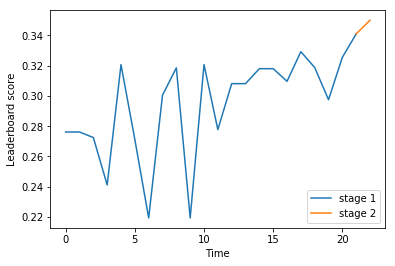

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.arange(len(scores) - 1), scores[:len(scores)-1], '-', label='stage 1')
plt.plot([21,22], scores[21:23], '-', label='stage 2')
plt.legend(loc=4)
plt.xlabel('Time')
plt.ylabel('Leaderboard score')

In [4]:
true_filename = './stage1_solution.csv'
scores = []
for file in filenames:
    if file != '.DS_Store':
        myZip = zipfile.ZipFile('sub/' + file)
        myZip.extractall('sub/')
        temp = os.listdir('sub/')
        for csvFile in temp:
            if csvFile.endswith('.csv'):
                pred_filename = 'sub/' + csvFile
                print(pred_filename)
                score = get_stage1_masks(true_filename, pred_filename)
                scores.append(score)
                print(score)
                os.remove(pred_filename)

sub/sub-dsbowl2018.csv


100%|██████████| 65/65 [00:12<00:00,  6.20it/s]


0.27615374884535643
sub/sub-dsbowl2018_new.csv


100%|██████████| 65/65 [00:14<00:00,  5.30it/s]


0.27615374884535643
sub/sub-dsbowl2018_3_15.csv


100%|██████████| 65/65 [00:13<00:00,  6.16it/s]


0.27249350765103797
sub/sub-dsbowl2018 _3_17.csv


100%|██████████| 65/65 [00:10<00:00,  6.51it/s]


0.24117553540438516
sub/sub-dsbowl2018_3_17.csv


100%|██████████| 65/65 [00:12<00:00,  6.23it/s]


0.3206625962526122
sub/sub-dsbowl2018_aug_3_17.csv


100%|██████████| 65/65 [00:13<00:00,  5.68it/s]


0.27117353168467734
sub/sub-dsbowl2018_3_17_2.csv


100%|██████████| 65/65 [00:11<00:00,  6.80it/s]


0.2193767094349294
sub/sub_4_4.csv


100%|██████████| 65/65 [00:12<00:00,  6.51it/s]


0.30046256860840437
sub/sub4_4(2).csv


100%|██████████| 65/65 [00:12<00:00,  6.37it/s]


0.31854790681578055
sub/sub-dsbowl2018_3_17_2.csv


100%|██████████| 65/65 [00:10<00:00,  6.86it/s]


0.2193767094349294
sub/sub-dsbowl2018_3_17.csv


100%|██████████| 65/65 [00:12<00:00,  6.34it/s]


0.3206625962526122
sub/sub_4_4.csv


100%|██████████| 65/65 [00:12<00:00,  6.32it/s]


0.27774717587665765
sub/sub_3_17_threshold=0.45.csv


100%|██████████| 65/65 [00:12<00:00,  4.31it/s]


0.014296306505185527
sub/sub-dsbowl2018.csv


100%|██████████| 65/65 [00:11<00:00,  4.57it/s]


0.01427963640173234
sub/sub-dsbowl2018.csv


100%|██████████| 65/65 [00:13<00:00,  4.01it/s]


0.014296306505185527
sub/sub-dsbowl2018.csv


100%|██████████| 65/65 [00:12<00:00,  3.77it/s]


0.01427963640173234
sub/sub-dsbowl2018.csv


100%|██████████| 65/65 [00:13<00:00,  5.69it/s]


0.30809089438855713
sub/sub-dsbowl2018.csv


100%|██████████| 65/65 [00:14<00:00,  6.08it/s]


0.30809089438855713
sub/sub-dsbowl2018.csv


100%|██████████| 65/65 [00:11<00:00,  6.47it/s]


0.31799344838165994
sub/sub-dsbowl2018.csv


100%|██████████| 65/65 [00:12<00:00,  5.90it/s]


0.31799344838165994
sub/sub-dsbowl2018.csv


100%|██████████| 65/65 [00:13<00:00,  5.59it/s]


0.309650654583821
sub/sub_4_6_kfold.csv


100%|██████████| 65/65 [00:13<00:00,  6.55it/s]


0.32922868332035765
sub/sub_4_6_kfold1.csv


100%|██████████| 65/65 [00:12<00:00,  6.57it/s]


0.31876279712927835
sub/sub_aug_100_10.csv


100%|██████████| 65/65 [00:13<00:00,  6.30it/s]


0.29748312734211313
sub/submission.csv


100%|██████████| 65/65 [00:15<00:00,  4.72it/s]


0.4191484625673837
sub/sub-dsbowl2018.csv


100%|██████████| 65/65 [00:13<00:00,  6.03it/s]


0.3255065379387185
sub/submit.csv


ValueError: invalid literal for int() with base 10: ''

In [ ]:
# Put the solution of stage1 here
true_filename = './stage1_solution.csv'
# Put your solution here
pred_filename = './dsbowl2018-1.csv'
print(get_stage1_masks(true_filename, pred_filename))